In [1]:
from __future__ import division
import pandas
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tqdm

import sys, os
sys.path.append('/mnt/disk0/home/jianwei_leejw/scripts/TESPulseFitCode')
import pulse_utils as pu
import trace_param as trcp
import pulse_fit_powell as pfp
import pickle
import heralded_pulses_analysis as hpa

In [2]:
results_directory='./'

In [24]:
data = pandas.read_csv(results_directory+\
#                        'results_newdisc_fixed_again.csv'
                       'results_newdisc_fixed_again_with_offset_extended_rejection.csv'
                      )
df = data[data['Unnamed: 0']!=np.nan]
df = df.drop_duplicates()
# print df.dtypes
# print len(df)
# print df[:1]

In [25]:
def model(numdata, bins, lims, plot=False):
    """
    Free running coherent state g2 (expected)
        Fixed Trace length T of bins
        g2 length g2_T of g2_bins
    """
    g2_T = np.diff(lims)*1e-9 
    g2_bins = bins
#     T = (10-1.978)*1e-6 # trace length - discriminator window around average single photon pulse = trace lengths containing only integer number of pulses
    T = (10-2)*1e-6
    dT = g2_T/g2_bins #g2 scope / bins in g2 scope
    bins = T/dT #bins in a trace
    prob = lambda tau,bins: 2/bins**2*(T-tau)/(dT)
    taus = np.linspace(dT/2,g2_T-dT/2,g2_bins)#g2 scope, bins in g2 scope
    if plot:
        plt.plot(taus*1e9,prob(taus,bins)*numdata,'-', linewidth=2, color='black')
    return prob(taus,bins)*numdata

In [26]:
def hist(data,numbins,lims, label='', plot=True, alpha=.5):
    """Creates and Plots numpy histogram, removing the last bin""" 
    y, binEdges = np.histogram(data,numbins,range=(lims))
    if plot:
        y_err = np.sqrt(y)
        step = binEdges[1]-binEdges[0]
        _bins = binEdges[:-1]+step/2
        plt.errorbar(_bins,y,yerr=y_err,fmt='.',color='blue', alpha=alpha)
        plt.xlim(lims)
    return y, _bins

In [175]:
bin_duration = 1 # ns
g2_duration = 10000
numbins = int(g2_duration/bin_duration)
lims = [0,g2_duration] #units ns

In [176]:
# df['tau'] = np.abs(df['two_x_offset_init']-df['one_x_offset_init'])*1e9
df['tau'] = np.abs(df['two_x_offset_fitted']-df['one_x_offset_fitted'])*1e9
maskAmp = df[['one_amplitude_fitted','two_amplitude_fitted']].sum(axis=1) < 1.45
maskTau = (np.abs(df['tau'])<2)
tau = df[:]['tau']
print np.sum(mask)
print np.sum(mask&mask1)
# print df[['fname','tau']]
print df[maskAmp][['one_amplitude_fitted','two_amplitude_fitted']].sum(axis=1)[:10]

248
191
13     1.412153
25     1.433029
33     1.412153
48     1.417483
56     1.412153
58     1.412153
78     1.429373
88     1.412153
92     1.412153
102    1.412153
dtype: float64


0.0153185129834


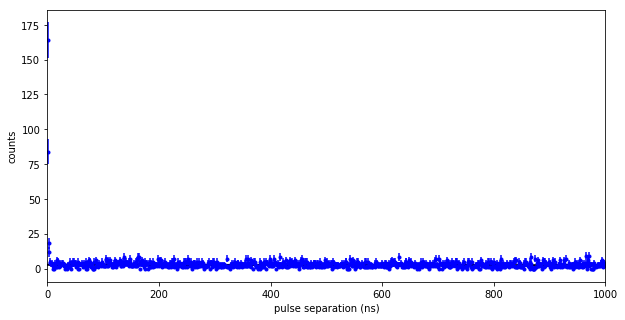

In [179]:
# plt.title('data folder = {}\n processed datafile: {}\n bin size = {}ns'.format(data_source, filename,bin_duration))
%matplotlib inline
tau = tau[:]
plt.figure(figsize=(10,5))
y, bins = hist(tau,numbins=numbins,lims=lims, plot=True, alpha=1)
y_model = model(len(tau), numbins, lims, plot=True)
print y[0]/sum(y)
plt.xlabel('pulse separation (ns)')
plt.ylabel('counts')
plt.xlim(0,1000)
# plt.ylim(0,np.max(y[1:])*1.2)
plt.savefig('')
plt.show()

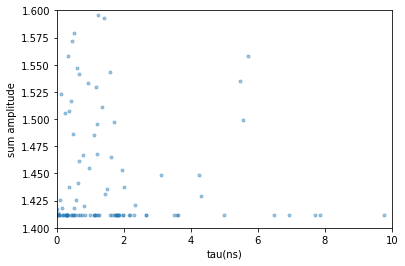

In [158]:
plt.figure()
plt.scatter(np.abs(df[:]['tau']),
            df[['one_amplitude_fitted','two_amplitude_fitted']].sum(axis=1)[:],
                     marker='.',alpha=0.4)
plt.xlim(np.min(df['tau']),np.max(df['tau']))
plt.xlabel('tau(ns)')
plt.xlim(0,10)
plt.ylim(1.4,1.6)
plt.ylabel('sum amplitude')

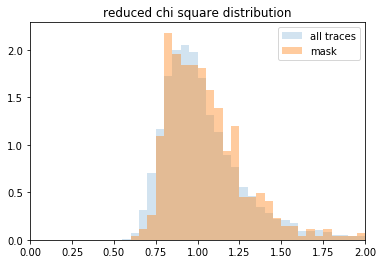

In [159]:
plt.figure()
plt.title('reduced chi square distribution')
mask = df['tau']<100
plt.hist(df[:]['redchi'],200,range=(0,10),normed=True,alpha=0.2,label='all traces');
plt.hist(df[mask]['redchi'],200,range=(0,10),normed=True,alpha=0.4, label='mask');
plt.xlim(0,2)
plt.legend()
plt.show()

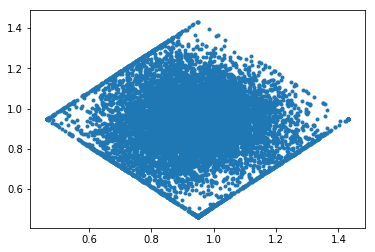

In [160]:
plt.figure()
plt.scatter(df[:]['one_amplitude_fitted'],
            df[:]['two_amplitude_fitted'],marker='.')
plt.show()

248


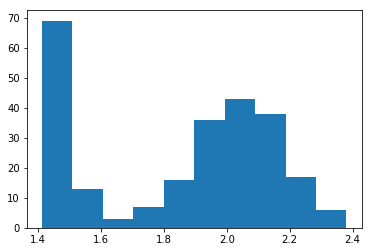

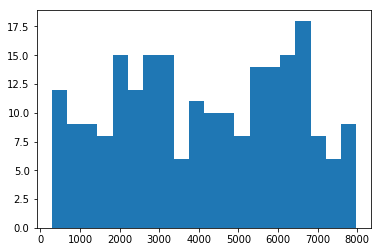

In [164]:
plt.figure()
mask = np.abs(df['tau'])<2
print np.sum(mask)
plt.hist(np.array(df[mask][['one_amplitude_fitted','two_amplitude_fitted']].sum(axis=1)),10);
plt.figure()
plt.hist(np.array(df[mask1]['two_x_offset_fitted'])*1e9,20);

## Troubleshooting

In [115]:
# mask1 = (np.abs(df['tau'])<1)

In [119]:
# Prepare to fit
[height_th, offset] = np.loadtxt(results_directory + 'disc_settings.dat')
offset = int(offset)
sigma0 = np.loadtxt(results_directory + 'rms.dat')
pulse_params =np.genfromtxt(results_directory + 'sum_and_diff_fit_params.dat',
                            delimiter="\t",
                            )
pkl_file = open(results_directory + 'two_pulse_fit_model.dat', 'rb')
two_pulse_fit = pickle.load(pkl_file)
print height_th, offset

0.00794093643656 650


In [120]:
# int_traces = np.loadtxt(results_directory + 'filelist_newdisc_errors.dat', dtype='string')
zero_traces = np.loadtxt(results_directory + 'filelist_zero_photon.dat', dtype='string')

In [121]:
mask1 = ~maskAmp&maskTau
l = np.array(df[mask1][['fname']][:np.sum(mask1)]).reshape(np.sum(mask1),)
np.sum(mask1)

224

[[Model]]
    (Model(one_pulse, prefix='one_') + Model(one_pulse, prefix='two_'))
[[Variables]]
    one_x_offset:      5.4140e-06 (init= 5.367252e-06)
    two_x_offset:      5.4154e-06 (init= 6.121252e-06)
    sum_amplitudes:    2.23703128 (init= 1.981632)
    diff_amplitudes:   0.48405186 (init= 0)
    one_amplitude:     1.36054157  == '(sum_amplitudes + diff_amplitudes)/2'
    two_amplitude:     0.87648970  == '(sum_amplitudes - diff_amplitudes)/2'

1.38396555327
( 13.0803501,  9.88690018,  0.03505888,  0.00723159)


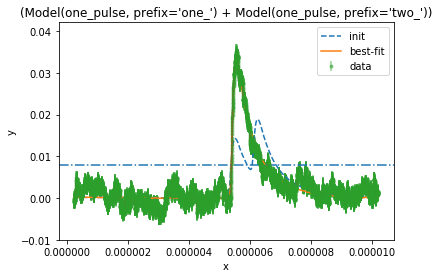

In [151]:
%matplotlib inline
reload(pu)
fname = '/mnt/disk1/data/20170523_TES5_75mK_95uA_trise_115ns/doubles/'+\
l[7]+'.trc'
# fname = int_traces[12]
time = pu.time_vector(fname)
signal = trcp.trace_extr(fname,height_th)
# Lmfit
reload(pfp)
r = pfp.fit_two_cw(time,signal,
              two_pulse_fit,
              pulse_params,
              height_th,
              sigma0)
print r.fit_report()
print (r.best_values['two_x_offset']-r.best_values['one_x_offset'])*1e9
r.plot_fit(data_kws={'marker':'.','alpha':0.5})
r.residual
# plt.xlim(r.best_values['one_x_offset']-3e-6,r.best_values['two_x_offset']+3e-6)
plt.axhline(height_th,linestyle='-.')
plt.plot(time,signal)
plt.ylim(-0.01,np.max(signal)*1.2)

reload(hpa)
print hpa.param_extr(fname,height_th,0,offset)
plt.legend()

## Stats on troublesome pulses

In [9]:
def path_extr(fnames):
    fullpathlist=[]
    directories = ['/mnt/disk1/data/20170523_TES5_75mK_95uA_trise_115ns/doubles/',
              '/mnt/disk1/data/20170523_TES5_75mK_95uA_trise_115ns/doubles_more/',
              '/mnt/disk1/data/20170523_TES5_75mK_95uA_trise_115ns/doubles_more_more/',
              '/mnt/disk1/data/20170523_TES5_75mK_95uA_trise_115ns/doubles_more_more_more/']
    for f in fnames:
        for d in directories:
            if os.path.isfile(d+f+'.trc'):
                fullpathlist.append(d+f+'.trc')
    return fullpathlist

In [517]:
fpl_13 = path_extr(df['fname'])

In [498]:
fpl_temp = path_extr(df['fname'])

In [499]:
fpl_diff=list(set(fpl_13) - set(fpl_temp))

In [502]:
print len(fpl_temp), len(fpl_13), len(fpl_diff)

8849 10681 2021


In [518]:
hpa.append2file(results_directory + 'filelist_13.dat',"\n".join(fpl_13))

In [528]:
trace_parameters_13 = np.array([hpa.param_extr(f,
                                   high_th = height_th,
                                   low_th = 0,
                                   offset = offset)
                   for f in tqdm.tqdm(fpl_13)])

100%|██████████| 10681/10681 [00:23<00:00, 449.85it/s]


In [547]:
int_area = trace_parameters_13['area_win']
mask=int_area<6
int_traces = np.array(fpl_13)[mask]

In [586]:
hpa.append2file(results_directory + 'filelist_newdisc_errors.dat',"\n".join(int_traces))

## Archive

In [ ]:
# for some reason this g2 plotting doesn't work:
freq, bins = np.histogram(np.abs(df['tau']), 
                          bins=int(g2_duration/bin_duration), 
                          range=(0,g2_duration))
bins = bins[:-1]+np.diff(bins)[0]/2

# plt.figure('arrival times _cont')
plt.bar(bins,freq,
        align='center',
        width=np.diff(bins)[0], 
        yerr=np.sqrt(freq))
plt.xlabel('time (ns)')
plt.ylim(0,np.max(freq)*1.2)
plt.ylim(0, 1000)
y_model = model(len(data), numbins, lims, plot=True)
plt.xlabel('pulse separation (ns)')
plt.ylabel('counts')
# plt.savefig(results_directory+'arrival_times_cont.pdf')
plt.show()